# Overview of the Code in this Notebook

This document provides a detailed explanation of each section in the notebook:

## Sections Explained

### Required Libraries
This section lists all the libraries necessary for the code to function properly. Ensure that these libraries are installed in your environment before running the code.

### Required Functions
This section is divided into several subsections:
- **Model Architecture**: Defines the structure and components of the model used in this project.
- **Empirical Wasserstein Distance Calculation**: Contains the function to compute the empirical Wasserstein distance, a key metric in this analysis.
- **Synthetic Data Generation**: Provides functions to create synthetic datasets for training and testing.
- **Data Loaders**: Includes functions to create training and testing data loaders.
- **Training and Evaluation Functions**: Outlines the procedures for training the model and evaluating its performance.

### Model Training and Sample Generation
This section is split into two parts:
- **Two Moon example**: Trains the model using the "Two Moon" dataset, generates samples, and plots the results.
- **Ellipse example**: Similarly, trains the model with the "Ellipse" dataset, generates samples, and plots the results.

All generated plots are viewable in the code output and are saved as files accessible via the 'Files' icon on the left-hand side.

### Wasserstein Distance Box Plots
This section of the code calculates the empirical Wasserstein distance across various noise conditions and generates two distinct box plots to visualize the results. These plots are available in the code output, as indicated at the bottom of the notebook, and can also be accessed through the 'Files' icon on the left-hand side after executing the entire notebook. This setup ensures that the results are readily viewable and verifiable.


# Required libraries

In [ ]:
import torch
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt
from  torch.utils.data import DataLoader, TensorDataset, SubsetRandomSampler, random_split
from torchvision import datasets, transforms
from torch.distributions.normal import Normal
from torch.distributions.uniform import Uniform
import torch.nn as nn
import torch.nn.functional as F
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from torch.autograd import Variable
import seaborn as sns

#Required functions

##Model Architecture

In [ ]:
DEEP_LAYER_SIZE = 100

In [ ]:
#weight Intialization
def gaussian_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('Linear') != -1:
        if classname.find('NonLinear') == -1:
            nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
#Architecture

################################################################################################
## Nonlinear structure
################################################################################################

class NonLinear(nn.Module):
    def __init__(self, input_size, output_size, bias=True, activation=None):
        super(NonLinear, self).__init__()

        self.activation = activation
        self.linear = nn.Linear(int(input_size), int(output_size), bias=bias)

    def forward(self, x):
        h = self.linear(x)
        if self.activation is not None:
            h = self.activation( h )

        return h

################################################################################################
## Encoder structure
################################################################################################

class Encoder(torch.nn.Module):
    def __init__(self, data_dim, cond_dim, latent_dim):
        ## n_hidden must be larger than 0!
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(data_dim + cond_dim, DEEP_LAYER_SIZE)
        self.fc1_bn = nn.BatchNorm1d(DEEP_LAYER_SIZE)
        self.fc2 = nn.Linear(self.fc1.out_features, DEEP_LAYER_SIZE)
        self.fc2_bn = nn.BatchNorm1d(DEEP_LAYER_SIZE)

        self.q_z_mean = nn.Linear(DEEP_LAYER_SIZE, latent_dim)
        self.q_z_logvar = NonLinear(DEEP_LAYER_SIZE, latent_dim, activation=nn.Hardtanh(min_val=-6.,max_val=2.))

        for m in self.modules():
            gaussian_init(m)

    def Sample_Z(self , z_mu , z_logvar):

        eps = torch.randn(z_logvar.shape).normal_().type(z_mu.type())

        sam_z = z_mu + (torch.exp(z_logvar / 2)) * eps

        return sam_z , eps

    #def forward(self, x,option):
    def forward(self , x, condition):
        x = torch.cat((x, condition), dim = -1)
        x = F.leaky_relu(self.fc1_bn(self.fc1(x)), 0.2)
        x = F.leaky_relu(self.fc2_bn(self.fc2(x)), 0.2)

        z_q_mean = self.q_z_mean(x)
        z_q_logvar = self.q_z_logvar(x)

        return z_q_mean, z_q_logvar

################################################################################################
## Decoder structure
################################################################################################

class Decoder(torch.nn.Module):
    def __init__(self, latent_dim, cond_dim, data_dim, var, learn_var=False):
        ## n_hidden must be larger than 0!
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim + cond_dim, DEEP_LAYER_SIZE)
        self.fc1_bn = nn.BatchNorm1d(DEEP_LAYER_SIZE)
        self.fc2 = nn.Linear(DEEP_LAYER_SIZE, DEEP_LAYER_SIZE)
        self.fc2_bn = nn.BatchNorm1d(DEEP_LAYER_SIZE)
        self.p_x_mean = nn.Linear(DEEP_LAYER_SIZE, data_dim)

        if learn_var == True:
            self.logvar = nn.Parameter(torch.log(var) , requires_grad=True)
        else:
            self.logvar = nn.Parameter(torch.log(var) , requires_grad=False)

        for m in self.modules():
            gaussian_init(m)

    def forward(self, z, condition):
        z = torch.cat((z, condition), dim = -1)
        z = F.leaky_relu(self.fc1_bn(self.fc1(z)), 0.2)
        z = F.leaky_relu(self.fc2_bn(self.fc2(z)), 0.2)

        x_mean = self.p_x_mean(z)
        return x_mean


################################################################################################
## VAE structure
################################################################################################

class condVAE(torch.nn.Module):
    def __init__(self, latent_dim, cond_dim, data_dim, var, learn_var=False):
        ## n_hidden must be larger than 0!
        super(condVAE, self).__init__()

        self.encoder = Encoder(data_dim, cond_dim, latent_dim)
        self.decoder = Decoder(latent_dim, cond_dim, data_dim, var, learn_var)


In [ ]:
#Loss Function

################################################################################################
## Calculate log pdf of normal distribution
################################################################################################

def logp_z(z , z_mu , z_logvar):
    ## z : mini_batch * z_dim
    ## z_mu , z_logvar : mini_batch * z_dim

    logp = -z_logvar/2-torch.pow((z-z_mu) , 2)/(2*torch.exp(z_logvar))

    return logp.sum(1)  ## (mini_batch,) vector

################################################################################################
## Calculate log pdf of normal distribution
## z ~ N(0,1)
################################################################################################

def logp_z_std_mvn(z):
    ## z : mini_batch * z_dim
    ## z_mu , z_logvar : mini_batch * z_dim

    logp = -torch.pow(z , 2)/2

    return logp.sum(1)  ## (mini_batch,) vector

################################################################################################
## Calculate log p(x|z;\theta)
################################################################################################

def logp_x_given_z(x , x_mu, x_logvar):
    '''
    ## x : mini_batch * x_dim
    ## x_mu : mini_batch * x_dim
    eps = 1e-5
    #logp = (x * torch.log(x_mu+eps) + (1. - x) * torch.log(1.-x_mu+eps)).sum(1)
    logp = (x * torch.log(x_mu+eps) + (1. - x) * torch.log(1.-x_mu+eps))
    '''
    logp = logp_z(x, x_mu, x_logvar)

    return logp

################################################################################################
## VAE loss function (w/ annealing)
################################################################################################

def vae_loss(x, condition, decoder , encoder, alpha):

    z_mu , z_logvar = encoder(x, condition)
    sam_z , _ = encoder.Sample_Z(z_mu , z_logvar)

    ## calculate weight
    log_p = logp_z_std_mvn(sam_z)
    log_q = logp_z(sam_z , z_mu , z_logvar)

    ## calculate RE
    x_mu = decoder(sam_z, condition)
    log_recon = logp_x_given_z(x , x_mu, decoder.logvar)

    ## loss
    log_loss = log_recon + alpha*(log_p - log_q)

    return -log_loss.mean()

## Empirical Wasserstein function

In [ ]:
###############################################
#############Sinkhorn###########################
###############################################
def sink(M, reg, numItermax=1000, stopThr=1e-9, cuda = True):

    # we assume that no distances are null except those of the diagonal of
    # distances

    if cuda:
        M = M.cuda()
        a = Variable(torch.ones((M.size()[0],)) / M.size()[0]).cuda()
        b = Variable(torch.ones((M.size()[1],)) / M.size()[1]).cuda()
    else:
        M = M.cpu()
        a = Variable(torch.ones((M.size()[0],)) / M.size()[0])
        b = Variable(torch.ones((M.size()[1],)) / M.size()[1])

    # init data
    Nini = len(a)
    Nfin = len(b)

    if cuda:
        u = Variable(torch.ones(Nini) / Nini).cuda()
        v = Variable(torch.ones(Nfin) / Nfin).cuda()
    else:
        u = Variable(torch.ones(Nini) / Nini)
        v = Variable(torch.ones(Nfin) / Nfin)

    # print(reg)

    K = torch.exp(-M / reg)
    K = torch.clamp(K, min=1e-35)  ## numerical stability
    # print(np.min(K))

    Kp = (1 / a).view(-1, 1) * K
    cpt = 0
    err = 1
    while (err > stopThr and cpt < numItermax):
        uprev = u
        vprev = v
        #print(T(K).size(), u.view(u.size()[0],1).size())
        KtransposeU = K.t().matmul(u)
        v = torch.div(b, KtransposeU)
        v = torch.clamp(v, max=1e+35)  ## numerical stability
        u = 1. / Kp.matmul(v)

        if cpt % 10 == 0:
            # we can speed up the process by checking for the error only all
            # the 10th iterations
            transp = u.view(-1, 1) * (K * v)
            err = (torch.sum(transp) - b).norm(1).pow(2).data#[0]

        cpt += 1

    P = u.view((-1, 1)) * K * v.view((1, -1))
    #entP = (-P*torch.log(P+1e-20)).sum()

    return torch.sum(P * M) #+reg*entP


def sink_stabilized(M, reg, numItermax=1000, tau=1e2, stopThr=1e-9, warmstart=None, print_period=20, cuda=True):

    if cuda:
        M = M.cuda()
        a = Variable(torch.ones((M.size()[0],)) / M.size()[0]).cuda()
        b = Variable(torch.ones((M.size()[1],)) / M.size()[1]).cuda()
    else:
        M = M.cpu()
        a = Variable(torch.ones((M.size()[0],)) / M.size()[0])
        b = Variable(torch.ones((M.size()[1],)) / M.size()[1])

    # init data
    na = len(a)
    nb = len(b)

    cpt = 0
    # we assume that no distances are null except those of the diagonal of
    # distances
    if warmstart is None:
        if cuda:
            alpha, beta = Variable(torch.zeros(na)).cuda(), Variable(torch.zeros(nb)).cuda()
        else:
            alpha, beta = Variable(torch.zeros(na)), Variable(torch.zeros(nb))
    else:
        alpha, beta = warmstart

    if cuda:
        u, v = Variable(torch.ones(na) / na).cuda(), Variable(torch.ones(nb) / nb).cuda()
    else:
        u, v = Variable(torch.ones(na) / na), Variable(torch.ones(nb) / nb)

    def get_K(alpha, beta):
        return torch.exp(-(M - alpha.view((na, 1)) - beta.view((1, nb))) / reg)

    def get_Gamma(alpha, beta, u, v):
        return torch.exp(-(M - alpha.view((na, 1)) - beta.view((1, nb))) / reg + torch.log(u.view((na, 1))) + torch.log(v.view((1, nb))))

    # print(np.min(K))

    K = get_K(alpha, beta)
    transp = K
    loop = 1
    cpt = 0
    err = 1
    while loop:

        uprev = u
        vprev = v

        # sinkhorn update
        v = torch.div(b, (K.t().matmul(u) + 1e-16))
        u = torch.div(a, (K.matmul(v) + 1e-16))

        # remove numerical problems and store them in K
        if torch.max(torch.abs(u)).data[0] > tau or torch.max(torch.abs(v)).data[0] > tau:
            alpha, beta = alpha + reg * torch.log(u), beta + reg * torch.log(v)

            if cuda:
                u, v = Variable(torch.ones(na) / na).cuda(), Variable(torch.ones(nb) / nb).cuda()
            else:
                u, v = Variable(torch.ones(na) / na), Variable(torch.ones(nb) / nb)

            K = get_K(alpha, beta)

        if cpt % print_period == 0:
            transp = get_Gamma(alpha, beta, u, v)
            err = (torch.sum(transp) - b).norm(1).pow(2).data[0]

        if err <= stopThr:
            loop = False

        if cpt >= numItermax:
            loop = False

        cpt += 1

    return torch.sum(get_Gamma(alpha, beta, u, v)*M)

def pairwise_distances(x, y, method='l1'):
    n = x.size()[0]
    m = y.size()[0]
    d = x.size()[1]

    x = x.unsqueeze(1)
    y = y.unsqueeze(0)

    if method == 'l1':
        dist = torch.abs(x - y).sum(2)
    else:
        dist = torch.pow(x - y, 2).sum(2).pow(0.5)

    return dist.float()

def dmat(x,y):
    mmp1 = torch.stack([x] * x.size()[0])
    mmp2 = torch.stack([y] * y.size()[0]).transpose(0, 1)
    mm = torch.sum((mmp1 - mmp2) ** 2, 2).squeeze()

    return mm


In [ ]:
def integratedW1(Real_sample, Model_sample, U_R, U_M):

    DistanceMatrix1 = pairwise_distances(Model_sample[U_M<0.5,:], Real_sample[U_R<0.5,:])
    DistanceMatrix2 = pairwise_distances(Model_sample[U_M>0.5,:], Real_sample[U_R>0.5,:])

    W11 = sink(DistanceMatrix1, reg = 0.01, cuda = False)
    W12 = sink(DistanceMatrix2, reg = 0.01, cuda = False)

    return 0.5*(W11+W12)

## Synthetic data generation

In [ ]:
#######################################
###     num = number of samples     ###
###    seed_d = seed distribution   ###
#######################################

def transform_ellipse(num, noise_var):
    unif = torch.rand(num)
    U = torch.rand(num)
    #U = torch.where(U>0.5, torch.ones_like(U), torch.zeros_like(U))

    pi = torch.pi

    eps1 = noise_var*torch.randn(num)
    eps2 = noise_var*torch.randn(num)

    cosa = (2*pi*unif).cos()
    sina = (2*pi*unif).sin()

    X = torch.where(U>0.5, 2*cosa, 1*cosa) + eps1
    Y = torch.where(U>0.5, sina, 0.5*sina) + eps2

    return torch.stack((U, X, Y), dim = -1).to(torch.float32)


def transform_twomoon(num, noise_var):
    unif = 0.5*torch.rand(num)
    U = torch.rand(num)
    #U = torch.where(U>0.5, torch.ones_like(U), torch.zeros_like(U))
    pi = torch.pi

    eps1 = noise_var*torch.randn(num)
    eps2 = noise_var*torch.randn(num)

    cosa = (2*pi*unif).cos()
    sina = (2*pi*unif).sin()

    shift = 2*3.5*4*2

    X = torch.where(U>0.5, cosa, 1 - cosa) + eps1
    Y = torch.where(U>0.5, sina, 1 - sina - 0.5) + eps2

    return torch.stack((U, X, Y), dim=-1).to(torch.float32)

## Data loaders:

In [ ]:
def get_dataload(generating_function_set, manifold_type, sample_size, batchsize, noise_var = 0.0):

    assert type(generating_function_set) == list
    assert type(manifold_type) == str
    assert type(sample_size) == int
    assert type(batchsize) == int

    if manifold_type == 'ellipse':
        transform = generating_function_set[0]
        samples = transform(sample_size, noise_var)

    elif manifold_type == 'twomoon':
        transform = generating_function_set[1]
        samples = transform(sample_size, noise_var)

    elif manifold_type == 'spiral':
        transform = generating_function_set[2]
        samples = transform(sample_size)

    elif manifold_type == '2Dtorus':
        transform = generating_function_set[3]
        samples = transform(sample_size)

    elif manifold_type == '2Dsphere':
        transform = generating_function_set[4]
        samples = transform(sample_size)


    train_size = int(0.8 * sample_size)
    test_size = sample_size - train_size

    train_data, test_data = random_split(samples, [train_size, test_size])

    train_loader = DataLoader(train_data, batch_size = batchsize, shuffle=True)
    test_loader = DataLoader(test_data, batch_size = batchsize, shuffle=False)

    return train_loader, test_loader

##Training and evaluation function

In [ ]:
################################################################################################
## Train function
################################################################################################
def train(epoch, train_loader, model, optimizer, cond_dim, data_dim):
    decoder = model.decoder
    encoder = model.encoder

    alpha = min(epoch/100, 1.)

    loss_vec = []

    for batch_id, sample in enumerate(train_loader):

        condition = sample[:, 0:cond_dim]
        data = sample[:, cond_dim:]

        i_loss = vae_loss(data, condition , decoder , encoder, alpha)

        optimizer.zero_grad()
        i_loss.backward()
        optimizer.step()

        loss_vec.append(i_loss.data.cpu().numpy())

    loss_vec = np.hstack(loss_vec)

    return loss_vec


################################################################################################
## eval function
################################################################################################
def eval(test_loader , model, cond_dim, data_dim):
    decoder = model.decoder
    encoder = model.encoder

    loss_vec = []

    for i,(sample) in enumerate(test_loader):

        condition = sample[:, 0:cond_dim]
        data = sample[:, cond_dim:]
        with torch.no_grad():
            i_loss = vae_loss(data, condition , decoder , encoder, 1.)

        loss_vec.append(i_loss.data.cpu().numpy())

    loss_vec = np.hstack(loss_vec)

    return loss_vec.mean()

# Model training and generating samples

In [ ]:
cond_dim = 1
data_dim = 2
latent_dim = 2
var = torch.tensor(1.)
transform = [transform_ellipse, transform_twomoon]

## Ellipse example

In [ ]:
Learn_SIG = True
max_epoch = 200
manifold = 'ellipse'
noise_var = 1e-4


train_load, test_load = get_dataload(generating_function_set=transform, manifold_type= manifold, sample_size = 5000, batchsize = 100, noise_var = noise_var)
model = condVAE(latent_dim, cond_dim, data_dim, var, Learn_SIG)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
losses = []
test_loss_store =  []

#model training
for epoch in range(max_epoch):
    model.train()
    loss_vec = train(epoch, train_load, model, optimizer, cond_dim, data_dim)

    model.eval()
    test_loss = eval(test_load, model, cond_dim, data_dim)

    losses.append(loss_vec.mean())
    test_loss_store.append(test_loss.mean())

    if epoch %50 == 49:
        print('training at the epoch number: ', epoch+1)


#Generating samples with trained model
model.eval()

size = 500

z = torch.randn(size, latent_dim)
U1 = 0.5*torch.rand(size).unsqueeze(1)
U2 = 0.5 + 0.5*torch.rand(size).unsqueeze(1)

with torch.no_grad():
  generated_1 = model.decoder(z, U1)
  generated_2 = model.decoder(z, U2)

#the base manifold
newdata = transform_ellipse(num=5000, noise_var = 0.)
newcondition = newdata[:,0]
newdata = newdata[:,1:]

#Let Plot the support of the scatter plot
plt.figure(figsize=(1.66*4, 1.436*4))

plt.scatter(newdata[newcondition > 0.5,0], newdata[newcondition > 0.5,1], label = '$G_*:$ Ellipse Out', s = 0.1, alpha = 0.15)
plt.scatter(newdata[newcondition < 0.5,0], newdata[newcondition < 0.5,1], label = '$G_*:$ Ellipse IN', s = 0.1, alpha = 0.15)

plt.scatter(generated_2[:,0], generated_2[:,1], label = '$\hat{g}:$ Ellipse Out', s = 0.25)
plt.scatter(generated_1[:,0], generated_1[:,1], label = '$\hat{g}:$ Ellipse In', s = 0.25)

plt.legend()

print('the scatter plot for the generated sample for ellipse is')


#Saving the plot
plt.savefig('Ellipse.png')

plt.show()

## Two Moon example

In [ ]:
Learn_SIG = True
max_epoch = 200
manifold = 'twomoon'
noise_var = 1e-4


train_load, test_load = get_dataload(generating_function_set=transform, manifold_type= manifold, sample_size = 5000, batchsize = 100, noise_var = noise_var)
model = condVAE(latent_dim, cond_dim, data_dim, var, Learn_SIG)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

training at the epoch number:  50
training at the epoch number:  100
training at the epoch number:  150
training at the epoch number:  200
the scatter plot for the generated sample for two moon is


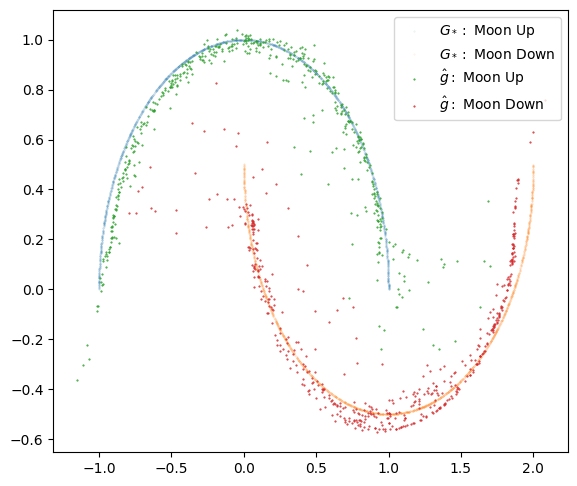

In [ ]:
losses = []
test_loss_store =  []

#model training
for epoch in range(max_epoch):
    model.train()
    loss_vec = train(epoch, train_load, model, optimizer, cond_dim, data_dim)

    model.eval()
    test_loss = eval(test_load, model, cond_dim, data_dim)

    losses.append(loss_vec.mean())
    test_loss_store.append(test_loss.mean())

    if epoch %50 == 49:
        print('training at the epoch number: ', epoch+1)


#Generating samples with trained model
model.eval()

size = 500

z = torch.randn(size, latent_dim)
U1 = 0.5*torch.rand(size).unsqueeze(1)
U2 = 0.5 + 0.5*torch.rand(size).unsqueeze(1)

with torch.no_grad():
  generated_1 = model.decoder(z, U1)
  generated_2 = model.decoder(z, U2)

#the base manifold
newdata = transform_twomoon(num=5000, noise_var = 0.)
newcondition = newdata[:,0]
newdata = newdata[:,1:]

#Let Plot the support of the scatter plot
plt.figure(figsize=(1.66*4, 1.436*4))

plt.scatter(newdata[newcondition > 0.5,0], newdata[newcondition > 0.5,1], label = '$G_*:$ Moon Up', s = 0.1, alpha = 0.15)
plt.scatter(newdata[newcondition < 0.5,0], newdata[newcondition < 0.5,1], label = '$G_*:$ Moon Down', s = 0.1, alpha = 0.15)

plt.scatter(generated_2[:,0], generated_2[:,1], label = '$\hat{g}:$ Moon Up', s = 0.25)
plt.scatter(generated_1[:,0], generated_1[:,1], label = '$\hat{g}:$ Moon Down', s = 0.25)

plt.legend()

print('the scatter plot for the generated sample for two moon is')


#Saving the plot
plt.savefig('Two_moon_sample.png')

plt.show()

# Wasserstein distance box plots

In [ ]:
##Trainign and Optimization (Specific Case)
scenarios = ['ellipse', 'twomoon']
epochlist = [200]
latent_dim_list = [2]
var = torch.tensor(1.)

##noise_varlist = [0.05, 0.08, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
noise_varlist = [0.05, 0.08, 0.1, 0.2, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

batchsize = 100
learning_rate = 1e-3
Learn_SIG = True
cond_dim = 1
data_dim = 2

In [ ]:
###Hyperparameter Empirical Wasserstein distance###
k = 20                                                                          #Number of times W1 computed
W1sample_size = 500                                                             #sample size

In [ ]:
transformation = [transform_ellipse, transform_twomoon]

In [ ]:
df_W_True = pd.DataFrame()

In [ ]:
for manifold_type in scenarios:
    for max_epoch in epochlist:
        for latent_dim in latent_dim_list:
            for noise_var in noise_varlist:
                print('-----------------------------------------------------------------')
                print('the manifold we are working is', manifold_type, ' with max epoch size', max_epoch,
                      ' the latent_dim is', latent_dim, ' and the noise variance is', noise_var, '.')

                train_load, test_load = get_dataload(generating_function_set=transformation,
                                                     manifold_type=manifold_type, sample_size = 5000, batchsize = batchsize,
                                                     noise_var = noise_var)

                model = condVAE(latent_dim, cond_dim, data_dim, var, Learn_SIG)
                optimizer = optim.Adam(model.parameters(), lr = learning_rate)

                losses = []
                test_loss_store =  []

                for epoch in range(max_epoch):
                    model.train()
                    loss_vec = train(epoch, train_load, model, optimizer, cond_dim, data_dim)

                    model.eval()
                    test_loss = eval(test_load, model, cond_dim, data_dim)

                    losses.append(loss_vec.mean())
                    test_loss_store.append(test_loss.mean())

                    if epoch %25 == 24:
                        print('training at the epoch number: ', epoch+1)




                #Computing Empirical W1 distance
                print('Computing the Empirical Wasserstein distance')

                W_true = torch.full((k,), float('nan'))                         #vector to store same sample W1

                index = scenarios.index(manifold_type)
                transform = transformation[1] if manifold_type == 'twomoon' else transformation[0]
                #transform = transformation[1]

                for j in range(k):
                    if (j+1) % 10 == 0:
                      print(j+1)

                    Real_1 = transform(num = W1sample_size, noise_var = noise_var)


                    U1 = Real_1[:, 0]

                    real_sam1 = Real_1[:, 1:]

                    #Generating sample from the trained model
                    z = torch.randn(W1sample_size, latent_dim)
                    U_model = U1.unsqueeze(1)

                    model.eval()
                    with torch.no_grad():
                      generated_sam = model.decoder(z, U_model)

                    #computing the W1 betwen real and generated sample
                    W_true[j] = integratedW1(generated_sam, real_sam1, U1, U1)


                #Storing the values

                df_W_True[str(manifold_type) + '; max-epoch='+ str(max_epoch) + '; latent='
                + str(latent_dim) + '; noise=' + str(noise_var)] =  W_true.numpy()

-----------------------------------------------------------------
the manifold we are working is ellipse  with max epoch size 200  the latent_dim is 2  and the noise variance is 0.05 .
training at the epoch number:  25
training at the epoch number:  50
training at the epoch number:  75
training at the epoch number:  100
training at the epoch number:  125
training at the epoch number:  150
training at the epoch number:  175
training at the epoch number:  200
Computing the Empirical Wasserstein distance
10
20
-----------------------------------------------------------------
the manifold we are working is ellipse  with max epoch size 200  the latent_dim is 2  and the noise variance is 0.08 .
training at the epoch number:  25
training at the epoch number:  50
training at the epoch number:  75
training at the epoch number:  100
training at the epoch number:  125
training at the epoch number:  150
training at the epoch number:  175
training at the epoch number:  200
Computing the Empirical W

In [ ]:
#Convert and store all data frame
df_W_True.to_csv('W1_true_200epochs_newnoise.csv', index = False, mode = 'w', header = True)

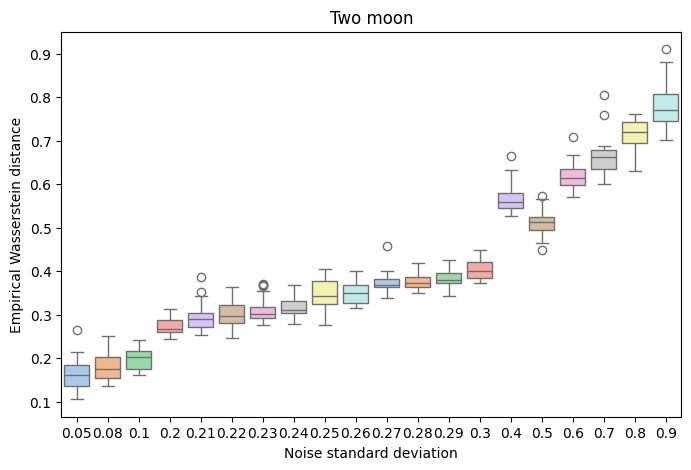

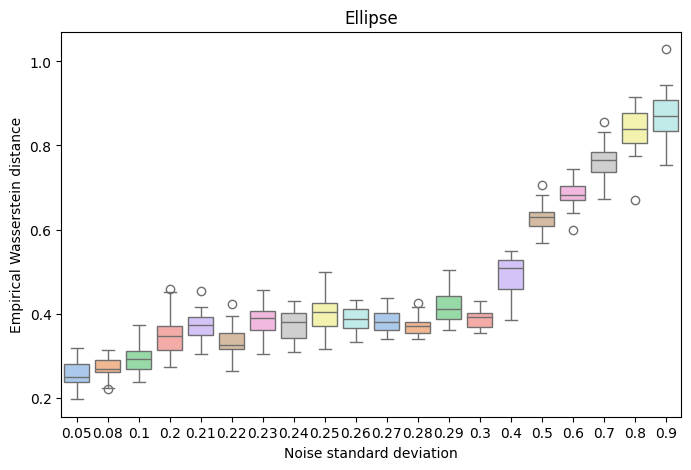

In [ ]:
# Load the data
df = pd.read_csv('W1_true_200epochs_newnoise.csv', header=None)
#df = df_W_True

# Extracting two moon and ellipse data
ellipse = []
twomoon = []

for col in df.columns:
    noise_info = df.iloc[0, col]
    noise = float(noise_info.split('noise=')[1])
    W_emp = df.iloc[1:, col].astype(float)
    if 'ellipse' in noise_info:
        ellipse.extend([(w, noise) for w in W_emp])
    elif 'twomoon' in noise_info:
        twomoon.extend([(w, noise) for w in W_emp])

# Creating dataframes
ellipse_df = pd.DataFrame(ellipse, columns=['W_emp', 'sigma'])
twomoon_df = pd.DataFrame(twomoon, columns=['W_emp', 'sigma'])

# Convert sigma to categorical
ellipse_df['sigma'] = ellipse_df['sigma'].astype('category')
twomoon_df['sigma'] = twomoon_df['sigma'].astype('category')

# Creating the twomoon boxplot
plt.figure(figsize=(8, 5))
sns.boxplot(x='sigma', y='W_emp', data=twomoon_df, hue='sigma', palette="pastel", dodge=False)
plt.title('Two moon')
plt.xlabel('Noise standard deviation')
plt.ylabel('Empirical Wasserstein distance')

plt.legend([],[], frameon=False)  # Remove legend
plt.savefig('twomoon_boxplot.png')
plt.show()

# Creating the ellipse boxplot
plt.figure(figsize=(8, 5))
sns.boxplot(x='sigma', y='W_emp', data=ellipse_df, hue='sigma', palette="pastel", dodge=False)
plt.title('Ellipse')
plt.xlabel('Noise standard deviation')
plt.ylabel('Empirical Wasserstein distance')

plt.legend([],[], frameon=False)  # Remove legend
plt.savefig('ellipse_boxplot.png')
plt.show()
